## A simple nonlinear problem
Let us consider the forward response (after Menke, 2012)
    $$f(m)= \sin(\omega m_1 x_i) + m_1 m_2$$
a nonlinear function in both model parameters $m_1$ and $m_2$.

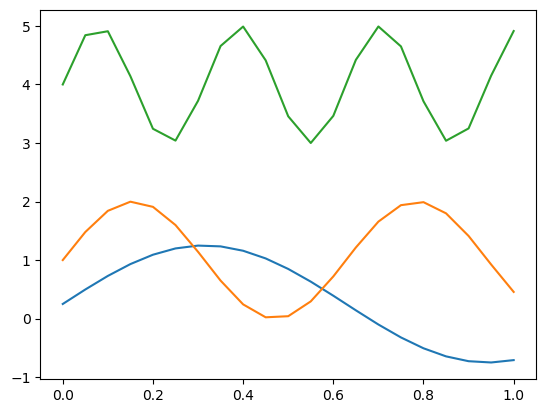

In [537]:
using PyPlot
using LinearAlgebra
x = 0:0.05:1;
omega=10
forward(m) = sin.(omega .* x .* m[1]) .+ m[1] .* m[2]
plot(x, forward([0.5, 0.5]))
plot(x, forward([1, 1]))
plot(x, forward([2, 2]));

Generation of synthetic data with some noise

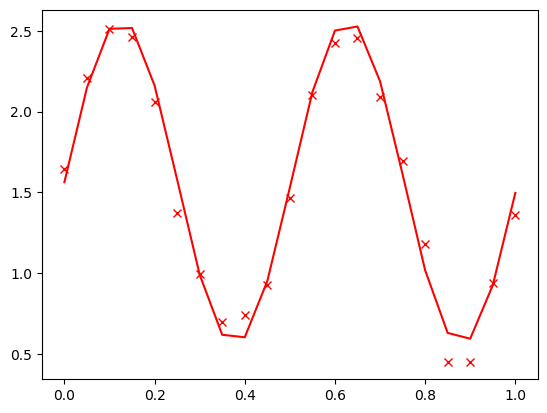

In [538]:
mSynth = [1.25, 1.25]
data = forward(mSynth);
plot(x, data, "r-")
data += randn(size(data))*0.1;
plot(x, data, "rx");

### The topology of the objective function
Computation of objective function for a range of model parameters

In [539]:
mrange = 0:0.01:2
Phi = zeros(length(mrange), length(mrange))
for i = 1:length(mrange)
    for j = 1:length(mrange)
        m1 = mrange[i]
        m2 = mrange[j]
        dpred = forward([m1, m2])
        Phi[j, i] = norm(data.-dpred)
    end
end

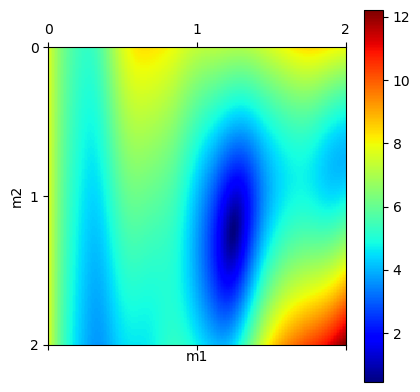

In [540]:
# Show objective function
matshow(Phi, extent=[mrange[1], mrange[end], mrange[end], mrange[1]])
xlabel("m1")
ylabel("m2")
set_cmap("jet")
colorbar();

In [541]:
# Let's check where the minumum is
argmin(Phi)

CartesianIndex(124, 126)

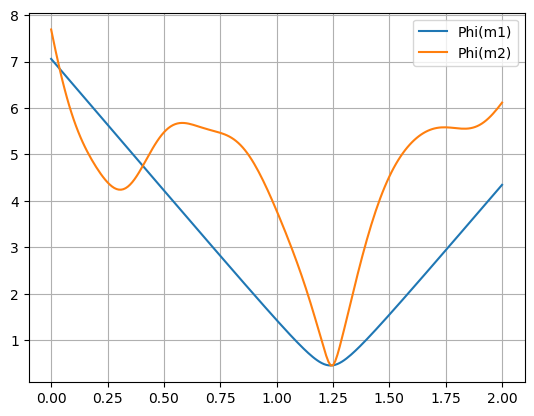

In [542]:
# Let's make two lines through the minimum
plot(mrange, Phi[:, Int(mSynth[2]*100)], label="Phi(m1)")
plot(mrange, Phi[Int(mSynth[1]*100), :], label="Phi(m2)")
grid()
legend();

The derivatives of the function 
 $$f(m)= \sin(\omega m_1 x_i) + m_1 m_2$$
with respect to $m_1$ and $m_2$ are
$$\frac{\partial f(m)}{\partial m_1} = \omega x_i \cos(\omega m_1 x_i) + m_2$$
$$\frac{\partial f(m)}{\partial m_2} = m_1$$

In [543]:
function sensitivity(modelVector) 
    Sens = zeros(length(x), 2)
    Sens[:, 1] = omega .* x .* cos.(omega.*x.*modelVector[1]) .+ modelVector[2]
    Sens[:, 2] = ones(length(x)) .* modelVector[1]
    return Sens
end;

### The steepest-descent method
Let us start at some model.

In [544]:
model = [2.0, 2.0]
fm = forward(model)
S = sensitivity(model)
gradient = transpose(S) * (data - fm)

2-element Array{Float64,1}:
 -134.25508992028836
 -105.56825803326383

In [545]:
function linesearch(data, modelN, deltaModelN, fak=1000, taumax=2)
    lsphi = zeros(fak*taumax)
    for i = 1:length(lsphi)
        modelN1 = modelN + deltaModelN .* (i/fak)
        lsphi[i] = norm(data-forward(modelN1))
    end
    return argmin(lsphi) / fak
end
tau = linesearch(data, model, gradient)
print(tau)
print(model+tau*gradient)

0.006[1.19446946047827, 1.366590451800417]

In [546]:
model = [0.7, 0.2]
fm = forward(model)
m1vec = [model[1]]
m2vec = [model[2]]
fitSD = [sum((data-fm).^2)]
for i = 1:20
    S = sensitivity(model)
    gradient = transpose(S) * (data - fm)
    tau = linesearch(data, model, gradient)
    print(tau)
    print(" ")
    model = model + gradient * tau
    fm = forward(model)
    append!(m1vec, model[1])
    append!(m2vec, model[2])
    append!(fitSD, norm(data-fm))
end

0.045 0.005 0.004 0.006 0.004 0.005 0.004 0.005 0.004 0.005 0.004 0.005 0.004 0.005 0.004 0.006 0.003 0.011 0.003 0.007 

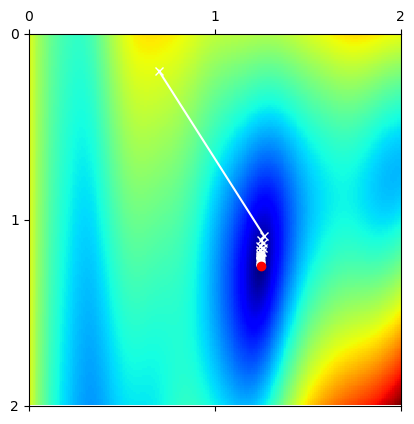

In [547]:
matshow(Phi, extent=[mrange[1], mrange[end], mrange[end], mrange[1]])
plot(m1vec, m2vec, "wx-")
# plot(m1vec, m2vec, "k+-")
plot(mSynth[1], mSynth[2], "ro");

### The Gauss-Newton method

In [548]:
model = [0.7, 0.2]
S = sensitivity(model)
dm = inv(transpose(S)*S+I*0.001) * (transpose(S) * (data-forward(model)))
print(dm)
tau = linesearch(data, model, dm)
print(tau)
print(model+dm*tau);

[-0.05315427890716845, 2.0138779981716715]1.116[0.6406798247396, 2.4474878459595857]

In [549]:
model = [0.8, 0.2]
fm = forward(model)
m1vec = [model[1]]
m2vec = [model[2]]
fitGN = [sum((data-fm).^2)]
for i = 1:20
    S = sensitivity(model)
    dm = inv(transpose(S)*S+I*100/i) * (transpose(S) * (data .- fm))
    tau = linesearch(data, model, dm)
    print(tau, " ")
    model += dm * tau
    fm = forward(model)
    append!(m1vec, model[1])
    append!(m2vec, model[2])
    append!(fitGN, norm(data-fm))
end

2.0 2.0 1.36 1.669 1.111 1.459 1.084 1.349 1.067 1.28 1.097 0.676 1.767 1.122 0.052 0.18 0.982 1.331 0.239 0.001 

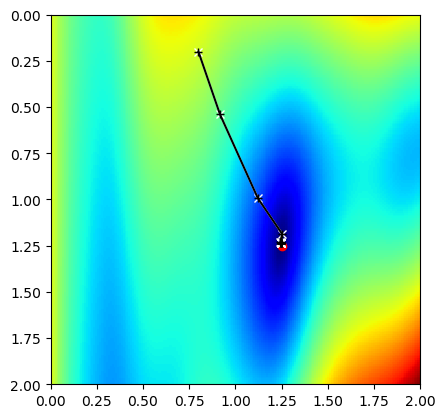

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000058E562C8>

In [550]:
imshow(Phi, extent=[mrange[1], mrange[end], mrange[end], mrange[1]])
plot(mSynth[1], mSynth[2], "ro");
plot(m1vec, m2vec, "wx-")
plot(m1vec, m2vec, "k+-")

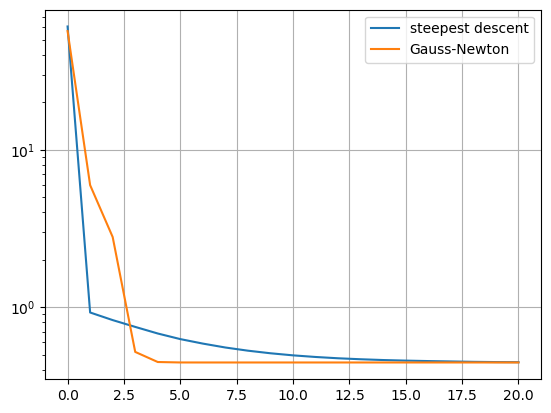

In [551]:
semilogy(fitSD, label="steepest descent");
semilogy(fitGN, label="Gauss-Newton");
grid()
legend();

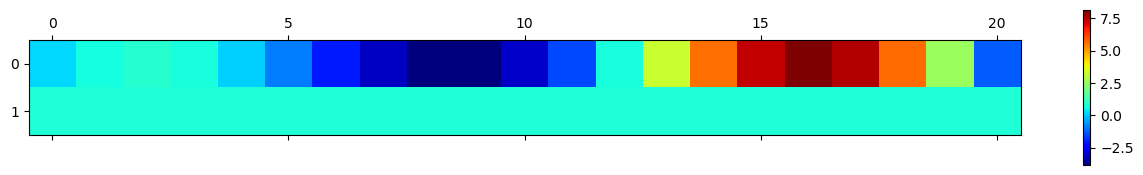

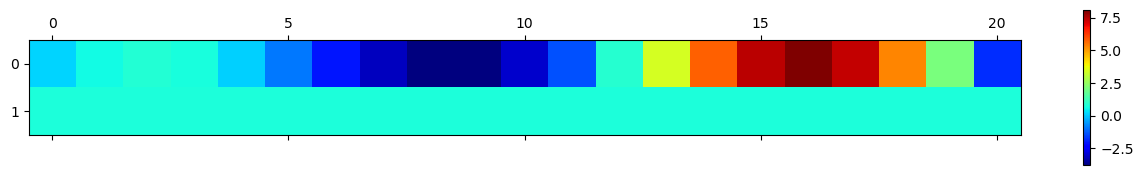

PyObject <matplotlib.colorbar.Colorbar object at 0x0000000058DE9988>

In [552]:
model = [0.8, 0.2]
fm = forward(model)
S = sensitivity(model)
matshow(transpose(S))
colorbar()
S1 = hcat(forward(model+[0.01, 0]).-fm, forward(model+[0, 0.01]).-fm) / 0.01
matshow(transpose(S1))
colorbar()